Here, I test whether my LSTM net works or not to estimate SGM parameters

I use the simulated data not the truth MEG

- As I use SGM_Net trained for 36-MEG data, I should use the same freqs 

In [1]:
RUN_PYTHON_SCRIPT = False

False

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [58]:
import numpy as np
import numpy.random as npr
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange, tqdm
from joblib import Parallel, delayed
import time

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [5]:
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.misc import get_cpt_ts
from utils.stable import paras_stable_check
from models.gpt import myNet
from models.model_utils import generate_position_encode
from models.loss import  weighted_mse_loss, reg_R_loss, lin_R_loss, lin_R_fn, reg_R_fn
from utils.standardize import std_mat, std_vec

In [6]:
# pkgs for pytorch ( Mar 27, 2023) 
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR

df_dtype = torch.float32
torch.set_default_dtype(df_dtype)
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_device("cpu")

In [7]:
seed = 1
import random
random.seed(seed)
np.random.seed(seed);
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True); 

# Data, fn and paras

In [8]:

def _get_cpt_ts_wrapper(length, ncpt, margin_size=None, mean_diff_sd=10, err_sd=1):
    """
    Generate a time series with change points.

    Parameters:
    - length (int): Length of the time series.
    - ncpt (int): Number of change points.
    - margin_size (int, optional): Size of the margin around the time series where change points cannot occur. If not provided, it is set to 10% of the length.
    - mean_diff_sd (float, optional): Standard deviation of the mean differences between segments. Default is 10.
    - err_sd (float, optional): Standard deviation of the error term. Default is 1.

    Returns:
    - ts (numpy.ndarray): Generated time series with change points.
    """
    if margin_size is None:
        margin_size = int(length*0.1)
    cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
    if ncpt >= 2:
        while np.diff(cpts).min() < margin_size:
            cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
        
    mean_diff = np.abs(npr.randn(ncpt))*mean_diff_sd + 5
    mean_diff = mean_diff * (-1)**np.arange(ncpt)
    ts = get_cpt_ts(mean_diff, cpts, err_sd, length=length)
    ts = ts - np.mean(ts)
    return ts

In [9]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc")) # 300/150
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all_full = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all_full = 10 * np.log10(psd_all_full) # to dB scale, 
# make it num_sub x num_roi x num_freqs x num_ts
psd_all_full = psd_all_full.transpose(3, 0, 1, 2)
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [10]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [11]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

In [12]:
# running parameters
# May change

paras_run = edict()

paras_run.n = 360
paras_run.n_sub = 50
# note k can differ from SGM_net
paras_run.k = 1.5 # the parameter for reparameterization in logistic
#paras_run.sd = 10 # The std to generate SGM parameters in raw scale (R)

# Generate simulated data

In [13]:
def _get_cpt_ts_wrapper(nseq, length, ncpt, margin_size=None, mean_diff_sd=10, err_sd=1):
    """
    Generate a time series with change points.

    Parameters:
    - length (int): Length of the time series.
    - ncpt (int): Number of change points.
    - margin_size (int, optional): Size of the margin around the time series where change points cannot occur. If not provided, it is set to 10% of the length.
    - mean_diff_sd (float, optional): Standard deviation of the mean differences between segments. Default is 10.
    - err_sd (float, optional): Standard deviation of the error term. Default is 1.

    Returns:
    - ts (numpy.ndarray): Generated time series with change points.
    """
    if margin_size is None:
        margin_size = int(length*0.1)
    cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
    if ncpt >= 2:
        while np.diff(cpts).min() < margin_size:
            cpts = np.sort(npr.choice(np.arange(1+margin_size, length-margin_size), size=ncpt, replace=False))
            
    tss = []
    for seq_idx in range(nseq):
        mean_diff = np.abs(npr.randn(ncpt))*mean_diff_sd + 5
        sign_idxs = (-1)**np.arange(ncpt)
        npr.shuffle(sign_idxs)
        mean_diff = mean_diff * sign_idxs
        ts = get_cpt_ts(mean_diff, cpts, err_sd, length=length)
        ts = (ts - np.mean(ts))/np.std(ts)
        tss.append(ts)
    return np.array(tss)

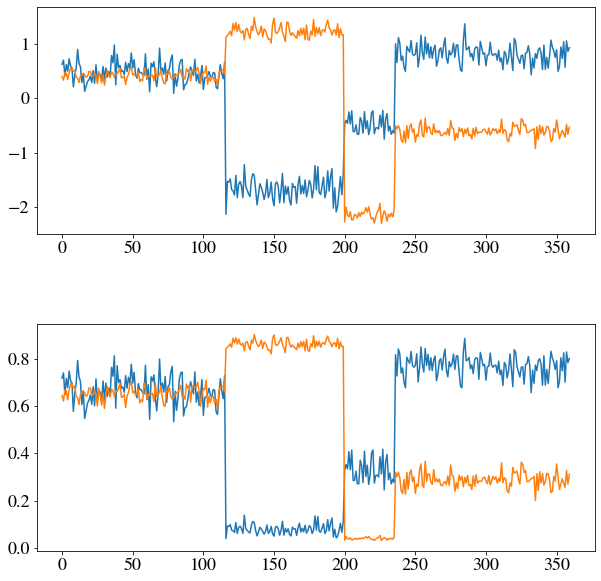

In [17]:
if not RUN_PYTHON_SCRIPT:
    from utils.reparam import logistic_np
    def raw2theta_np(thetas_raw, prior_bds, k):
        """transform reparameterized theta to orignal theta
            args: thetas_raw: an array with num_sps x 7
                  prior_bds: an array with 7 x 2                                                                                                                               
        """
        thetas = logistic_np(thetas_raw, k=k)*(prior_bds[:, 1] -  prior_bds[:, 0]) + prior_bds[:, 0]
        return thetas
    
    data = _get_cpt_ts_wrapper(2, paras_run.n, 3, mean_diff_sd=10)
    data1 = raw2theta_np(data, np.array([[0, 1]]), k=paras_run.k)
    plt.figure(figsize=[10, 10])
    plt.subplot(211)
    plt.plot(data[0])
    plt.plot(data[1])
    plt.subplot(212)
    plt.plot(data1[0])
    plt.plot(data1[1])

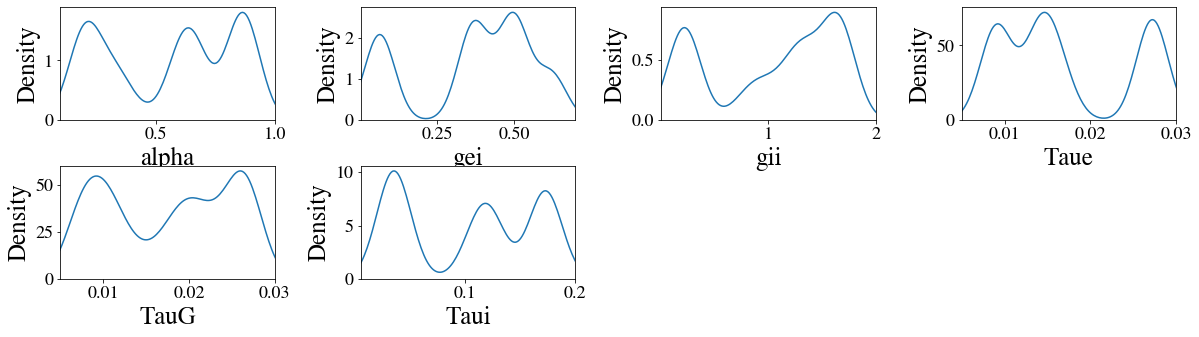

In [18]:
# show demo of generatingt simulation data (Speed is a constant, Mar 30, 2023)
if not RUN_PYTHON_SCRIPT:
    ts_nospeed = _get_cpt_ts_wrapper(6, 1000, ncpt=3).T
    ts_speed = np.repeat(np.random.randn(1), 1000)
    sgm_paramss_raw = np.concatenate([ts_nospeed, ts_speed.reshape(-1, 1)], axis=1)
    sgm_paramss = raw2theta_np(sgm_paramss_raw, paras.prior_bds, k=paras_run.k)
    #sgm_paramss = raw2theta_np(sgm_paramss_raw, paras.prior_bds, k=paras_run.k)
    
    plt.figure(figsize=[20, 5])
    for ix in range(6):
        plt.subplot(2, 4, ix+1)
        sns.kdeplot(sgm_paramss[:, ix])
        plt.xlim(paras.prior_bds[ix, :])
        plt.xlabel(paras.names[ix])

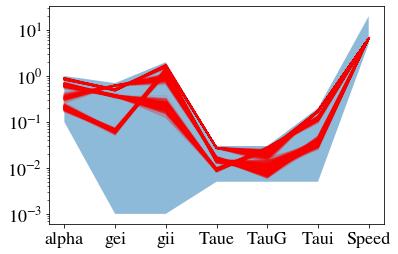

In [19]:
#check the reparameterization
if not RUN_PYTHON_SCRIPT:
    plt.fill_between(np.arange(7), paras.par_low, paras.par_high, alpha=0.5)
    plt.yscale("log")
    for cur_ts_sgm in sgm_paramss:
        plt.plot(np.arange(7), cur_ts_sgm, color="red", alpha=0.1)
    plt.xticks(np.arange(7), paras.names);
    plt.show()
    plt.close()

In [21]:
# Gerenate data when speed is a constant
sgm_paramsss = []
PSDss = []
for sub_ix in range(paras_run.n_sub):
    ts_dyn = _get_cpt_ts_wrapper(nseq=3, length=paras_run.n, ncpt=3).T
    ts_taus = np.repeat(np.random.randn(3)[:, None], paras_run.n, axis=1).T
    ts_speed = np.repeat(np.random.randn(1), paras_run.n)
    sgm_paramss_raw = np.concatenate([ts_dyn, ts_taus, ts_speed.reshape(-1, 1)], axis=1)
    
    sgm_paramss = raw2theta_np(sgm_paramss_raw, paras.prior_bds, k=paras_run.k)
    sgmmodel = SGM(paras.C, paras.D, paras.freqs)
    def _run_fn(cur_sgm):
        cur_PSD = sgmmodel.run_local_coupling_forward(cur_sgm)
        cur_PSD = cur_PSD[:68, :]
        return cur_PSD
    with Parallel(n_jobs=20) as parallel:
        PSDs = parallel(delayed(_run_fn)(cur_sgm) for cur_sgm in tqdm(sgm_paramss, 
                                                                      desc=f"sub {sub_ix+1}/{paras_run.n_sub}", 
                                                                      total=paras_run.n))
    sgm_paramsss.append(sgm_paramss)
    PSDss.append(PSDs)
    
simu_sgm_data = edict()
simu_sgm_data.PSDss = np.array(PSDss)
simu_sgm_data.sgm_paramsss =sgm_paramsss
save_pkl_dict2folder(RES_ROOT/f"simu_cptts_sgm_data_contauspeed", simu_sgm_data, is_force=True)

sub 50/50: 100%|███████████████████████████████████████████████████████████████| 360/360 [00:10<00:00, 35.62it/s]


Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_cptts_sgm_data_contauspeed/PSDss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_cptts_sgm_data_contauspeed/sgm_paramsss.pkl


# Train the model

In [38]:
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_cptts_sgm_data_contauspeed");

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_cptts_sgm_data_contauspeed/PSDss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/simu_cptts_sgm_data_contauspeed/sgm_paramsss.pkl


In [39]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net", excluding=['opt*']);
sgm_net = trained_model.model
sgm_net.to(dtype=df_dtype);
sgm_net.eval();

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net/paras.pkl


In [24]:
def _evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data, dtype=df_dtype)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    with torch.no_grad():
        Y_pred, _ = net(all_data_input+pos_enc);
        X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = reg_R_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(num_sub, len_seq, -1)
    return corrs.detach().numpy()

In [25]:
config = edict()
config.nfeature = 39 * 68 # the dim of features at each time point
config.target_dim = 7 # the target dim 
config.ndim = 256 # the output of the first FC layer
config.dropout = 0.0 # the dropout rate
config.n_layer = 2 # the number of self-attention layers
config.n_head = 8 # numher of heads for multi-head attention
config.is_mask = False # Use mask to make the attention causal
config.is_bias = True # Bias  for layernorm
config.block_size = 360 # the preset length of seq, 
config.batch_size = 1 # the batch size
config.k = 1
config.dy_mask = torch.tensor([1, 1, 1, 1, 1, 1, 0], dtype=df_dtype)

pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0)

paras_train = edict()
paras_train.niter = 1000
paras_train.loss_out = 1
paras_train.loss_pen_w = 3
paras_train.eval_out = 20
paras_train.clip = 10 # from 
paras_train.lr_step = 10
paras_train.gamma = 0.9 #!!!! 0.5
paras_train.lr = 1e-4 
paras_train.unstable_pen = 10000
paras_train.loss_name = "wmse"


post_fix = "_datataufixed"
stat_part = "_".join(np.array(paras.names)[np.array(config.dy_mask)==0][:-1])
if len(stat_part) > 0:
    folder_name = f"GPT_simu_net_simudatacpt_{paras_train.loss_pen_w*10}_{paras_train.loss_name}_{stat_part}{post_fix}";
else:
    folder_name = f"GPT_simu_net_simudatacpt_{paras_train.loss_pen_w*10}_{paras_train.loss_name}{post_fix}";
paras_train.save_dir = RES_ROOT/folder_name
print(paras_train.save_dir)



#  all_data should be num_sub x len_seq x nrois x nfreqs
#  or len_seq x nrois x nfreqs
all_data = simu_sgm_data.PSDss

all_data_raw = torch.tensor(all_data, dtype=df_dtype)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);
# input should be num_sub x len_seq unlike lstm

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed


In [26]:
net = myNet(config, 
           prior_bds=torch.tensor(paras.prior_bds, dtype=df_dtype));

net.to(dtype=df_dtype);
if paras_train.loss_name.startswith("corr"):
    loss_fn = reg_R_loss
elif paras_train.loss_name.startswith("linR"):
    loss_fn = lin_R_loss
elif paras_train.loss_name.startswith("wmse"):
    loss_fn = weighted_mse_loss
elif paras_train.loss_name.startswith("mse"):
    loss_fn = nn.MSELoss()
else:
    raise KeyError("No such loss")

optimizer = torch.optim.AdamW(net.parameters(), lr=paras_train.lr, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=paras_train.gamma, verbose=True)

number of parameters: 2.26M
Adjusting learning rate of group 0 to 1.0000e-04.


In [27]:
# training
loss_cur = 0
loss_pen_cur = 0
losses = []
losses_pen = []
losses_test = []

t0 = time.time()
sgm_net.eval()
loss_add = 0
for ix in range(paras_train.niter):
    net.train()
    X_seq = all_data_input
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred, loss_pen = net(X_seq)
    loss_pen = loss_pen[net.config.dy_mask==1].mean()
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss_main = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    if paras_train.unstable_pen > 0:
        unstable_inds = paras_stable_check(theta_pred.flatten(0, 1).detach().numpy());
        unstable_inds = torch.tensor(unstable_inds).reshape(*theta_pred.shape[:2])
        loss_add = (paras_train.unstable_pen * unstable_inds.unsqueeze(-1) * theta_pred).mean();
    loss = loss_main + loss_add + paras_train.loss_pen_w * loss_pen
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(net.parameters(), paras_train.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_train.lr_step == (paras_train.lr_step-1):
        scheduler.step()
    
    loss_cur = loss_cur + loss_main.item()
    loss_pen_cur = loss_pen_cur + loss_pen.item()
    if ix % paras_train.loss_out == (paras_train.loss_out-1):
        losses.append(loss_cur/paras_train.loss_out)
        losses_pen.append(loss_pen_cur/paras_train.loss_out)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses are {loss_cur/paras_train.loss_out:.5f} (train). "
              f"the pen losses are {loss_pen_cur/paras_train.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        loss_pen_cur = 0
        t0 = time.time()
        
    if ix % paras_train.eval_out == (paras_train.eval_out-1):
        net.eval()
        loss_test = _evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()
    


At iter 1/1000, the losses are 3.89650 (train). the pen losses are 0.00650 (train). The time used is 3.440s. 
At iter 2/1000, the losses are 3.43924 (train). the pen losses are 0.00673 (train). The time used is 2.800s. 
At iter 3/1000, the losses are 3.05106 (train). the pen losses are 0.00727 (train). The time used is 2.857s. 
At iter 4/1000, the losses are 2.77372 (train). the pen losses are 0.00812 (train). The time used is 2.874s. 
At iter 5/1000, the losses are 2.73605 (train). the pen losses are 0.00895 (train). The time used is 2.864s. 
At iter 6/1000, the losses are 2.66102 (train). the pen losses are 0.00946 (train). The time used is 2.919s. 
At iter 7/1000, the losses are 2.57451 (train). the pen losses are 0.00969 (train). The time used is 2.861s. 
At iter 8/1000, the losses are 2.53346 (train). the pen losses are 0.00980 (train). The time used is 2.723s. 
At iter 9/1000, the losses are 2.51030 (train). the pen losses are 0.00988 (train). The time used is 2.749s. 
Adjusting 

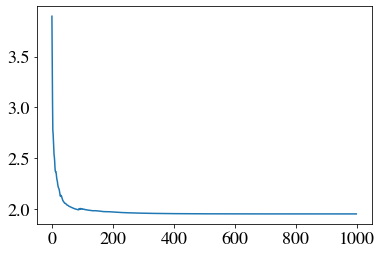

In [28]:
plt.plot(losses)
#plt.yscale("log")

In [29]:
net.eval()
with torch.no_grad():
    Y_pred, _ = net(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy();

In [30]:
sgm_paramss_est.shape

(50, 360, 7)

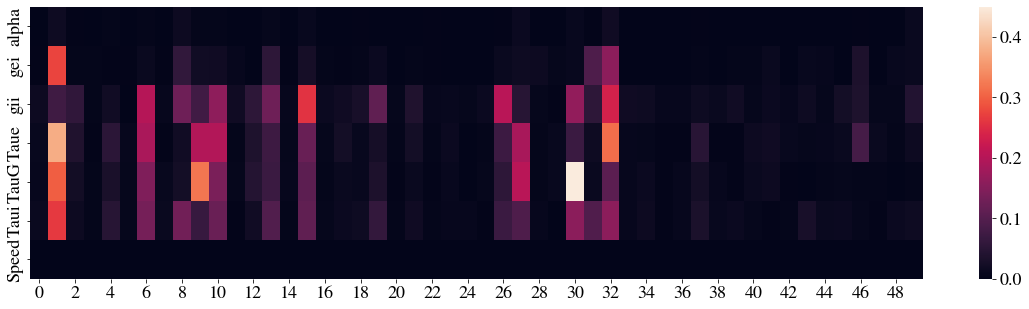

In [31]:
pred_params = sgm_paramss_est[:, :]
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

In [32]:
np.median(CVs, axis=0)

array([1.3883777e-03, 4.9227723e-03, 1.7665602e-02, 1.0878540e-02,
       9.2166513e-03, 1.2977775e-02, 2.6209864e-06], dtype=float32)

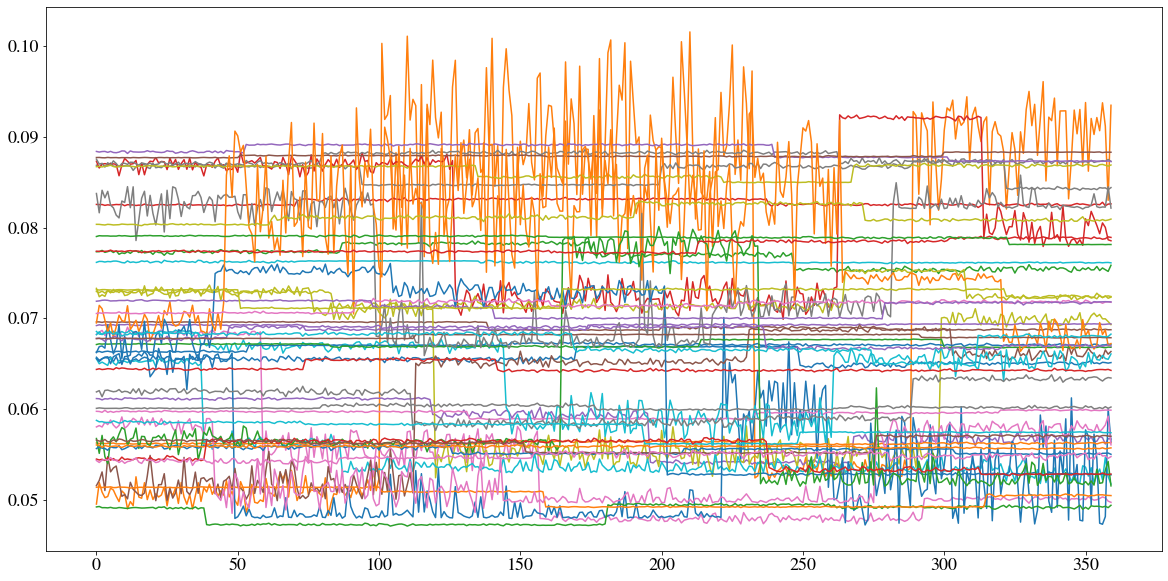

In [33]:
para_ix = 5
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

In [36]:
if (paras_train.save_dir).exists():
    trained_model = load_pkl_folder2dict(paras_train.save_dir)
else:
    trained_model = edict()
    trained_model.model = net
    trained_model.loss_fn = loss_fn
    trained_model.optimizer = optimizer
    trained_model.paras = paras_train
    trained_model.config = config
    trained_model.loss = losses
    save_pkl_dict2folder(paras_train.save_dir, trained_model, is_force=True)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss.pkl


In [71]:
trained_model.model.eval()
with torch.no_grad():
    Y_pred, _ = trained_model.model(all_data_input)
sgm_paramss_est = Y_pred.cpu().numpy()
trained_model.sgm_paramss_est = sgm_paramss_est
save_pkl_dict2folder(paras_train.save_dir, trained_model, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/config.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/sgm_paramss_est.pkl


# Evaluate

## SGM parameters

In [40]:
save_dir = RES_ROOT/"GPT_simu_net_simudatacpt_30_wmse_datataufixed"
trained_model = load_pkl_folder2dict(save_dir);
simu_sgm_data = load_pkl_folder2dict(RES_ROOT/"simu_cptts_sgm_data_contauspeed");

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/config.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/loss_fn.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/optimizer.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/paras.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net_simudatacpt_30_wmse_datataufixed/sgm_params

In [41]:
true_params = np.array(simu_sgm_data.sgm_paramsss)
pred_params = trained_model.sgm_paramss_est;

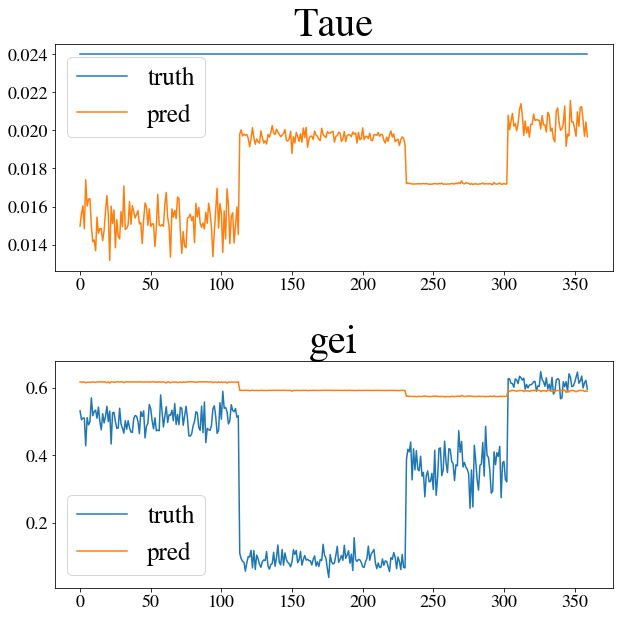

In [69]:
sub_ix = 15
plt.figure(figsize=[10, 10])
plt.subplot(211)
para_ix = 3
plt.title(f"{paras.names[para_ix]}", fontsize=40)
plt.plot(true_params[sub_ix, :, para_ix], label="truth")
plt.plot(pred_params[sub_ix, :, para_ix], label="pred")
plt.legend()
plt.subplot(212)
para_ix = 1
plt.title(f"{paras.names[para_ix]}", fontsize=40)
plt.plot(true_params[sub_ix, :, para_ix], label="truth")
plt.plot(pred_params[sub_ix, :, para_ix], label="pred")
plt.legend()

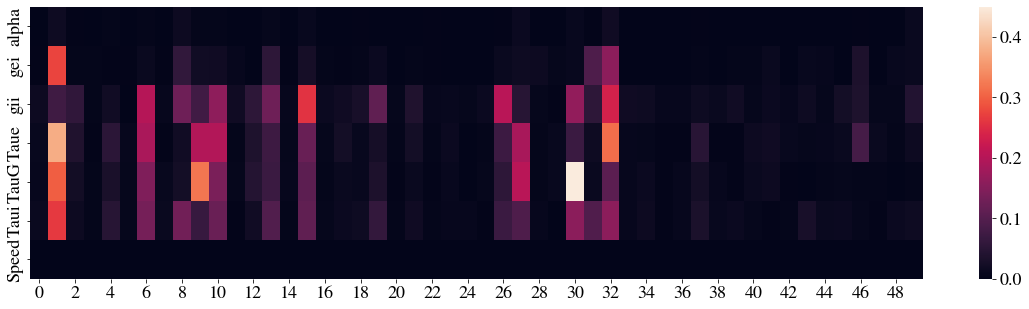

In [42]:
CVs = pred_params.std(axis=1)/pred_params.mean(axis=1)
plt.figure(figsize=[20, 5])
sns.heatmap(CVs.T, annot=False)
plt.yticks(np.arange(len(paras.names))+0.5, paras.names);

In [18]:
np.median(CVs, axis=0)

array([1.3883777e-03, 4.9227723e-03, 1.7665602e-02, 1.0878540e-02,
       9.2166513e-03, 1.2977775e-02, 2.6209864e-06], dtype=float32)

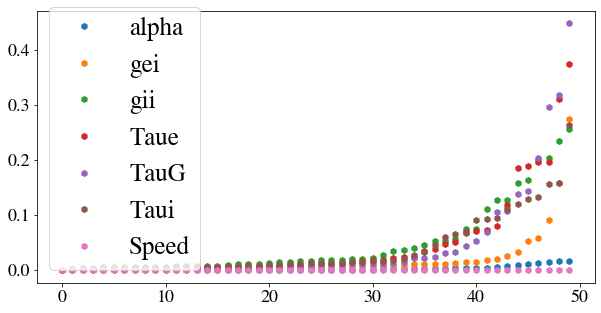

In [19]:
plt.figure(figsize=[10, 5])
for para_ix in range(7):
    plt.plot(np.sort(CVs[:, para_ix]), "h", label=f"{paras.names[para_ix]}")
plt.legend()

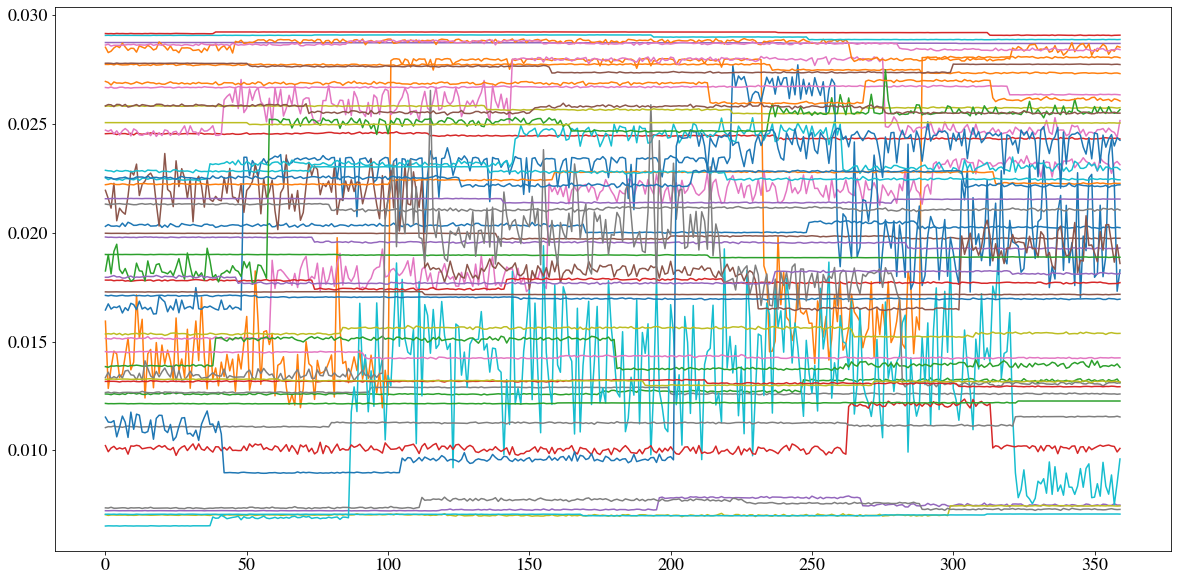

In [26]:
para_ix = 4
plt.figure(figsize=[20, 10])
for sub_ix in range(pred_params.shape[0]):
    plt.plot(pred_params[sub_ix, :, para_ix])

### Can recover truth?

In [27]:
dy_mask = np.array(trained_model.config.dy_mask);

In [28]:
# not need speed
true_params_flt = true_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, true_params.shape[1])
pred_params_flt = pred_params[:, :, dy_mask==1].transpose(0, 2, 1).reshape(-1, pred_params.shape[1]);
true_params_stat = true_params[:, 0, dy_mask==0]
pred_params_stat = pred_params[:, 0, dy_mask==0]
dyn_names = np.array(paras.names)[dy_mask==1]
stat_names = np.array(paras.names)[dy_mask==0]
num_dyn_params = (dy_mask==1).sum();

#### Static

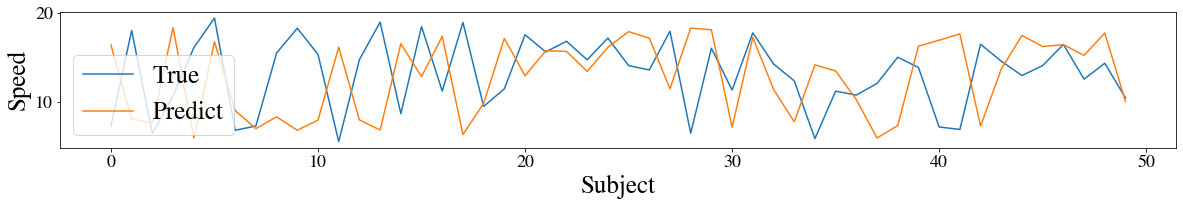

In [29]:
plt.figure(figsize=[20, 2.5*len(stat_names)])
for para_ix in range(len(stat_names)):
    plt.subplot(len(stat_names), 1, para_ix+1)
    plt.plot(true_params_stat[:, para_ix], label="True")
    plt.plot(pred_params_stat[:, para_ix], label="Predict")
    plt.xlabel("Subject")
    plt.ylabel(stat_names[para_ix])
    plt.legend()

#### Reg R

In [30]:

corrs = reg_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);
corrs1, pvals = [], []
for ix in range(true_params_flt.shape[0]):
    rv, pval = scipy.stats.pearsonr(true_params_flt[ix, :], pred_params_flt[ix, :])
    corrs1.append(rv)
    pvals.append(pval)
corrs1 = np.array(corrs1).reshape(-1, num_dyn_params)
pvals = np.array(pvals).reshape(-1, num_dyn_params);

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/loss.py:45: RuntimeWarning: invalid value encountered in true_divide
  corrs = num/den
/opt/conda/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


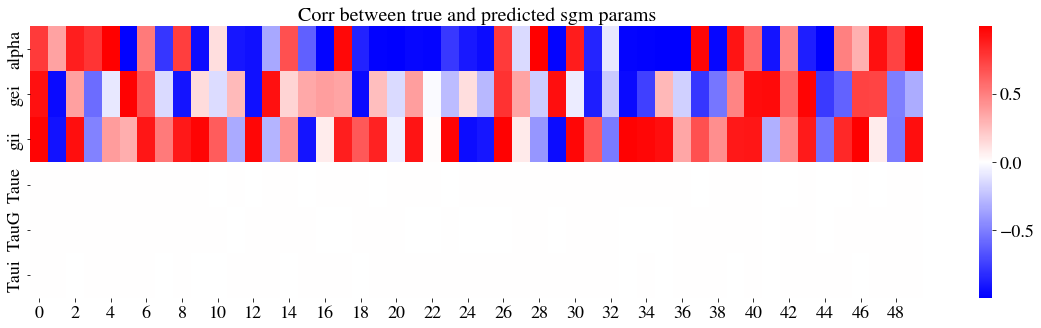

In [31]:
plt.figure(figsize=[20, 5])
plt.title(f"Corr between true and predicted sgm params", fontsize=20)
sns.heatmap(corrs.T, cmap="bwr", center=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

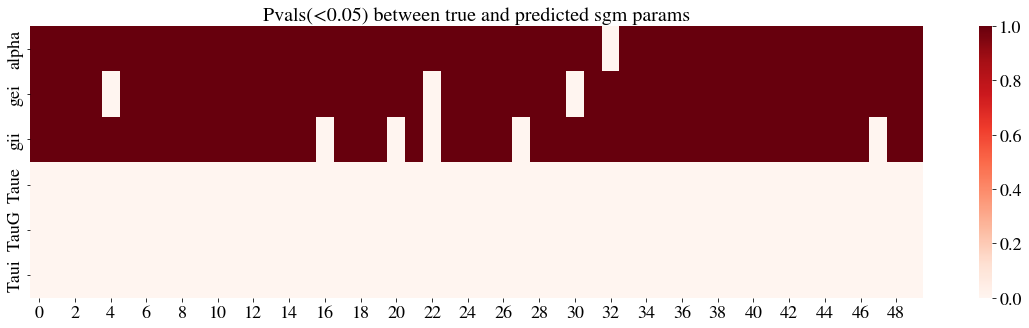

In [32]:
plt.figure(figsize=[20, 5])
plt.title(f"Pvals(<0.05) between true and predicted sgm params", fontsize=20)
sns.heatmap(pvals.T<0.05, cmap="Reds", vmin=0)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

#### MSE

/tmp/ipykernel_60347/1651260520.py:6: RuntimeWarning: divide by zero encountered in true_divide
  sns.heatmap((mses/stds).T, cmap="Reds", vmin=0, annot=False)


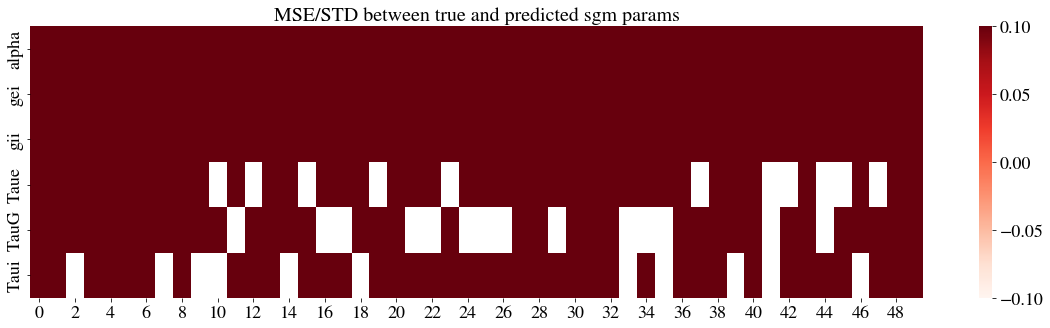

In [33]:
mses = np.mean((true_params_flt - pred_params_flt)**2, axis=1).reshape(-1, num_dyn_params);
stds = true_params_flt.std(axis=1).reshape(-1, num_dyn_params)

plt.figure(figsize=[20, 5])
plt.title(f"MSE/STD between true and predicted sgm params", fontsize=20)
sns.heatmap((mses/stds).T, cmap="Reds", vmin=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

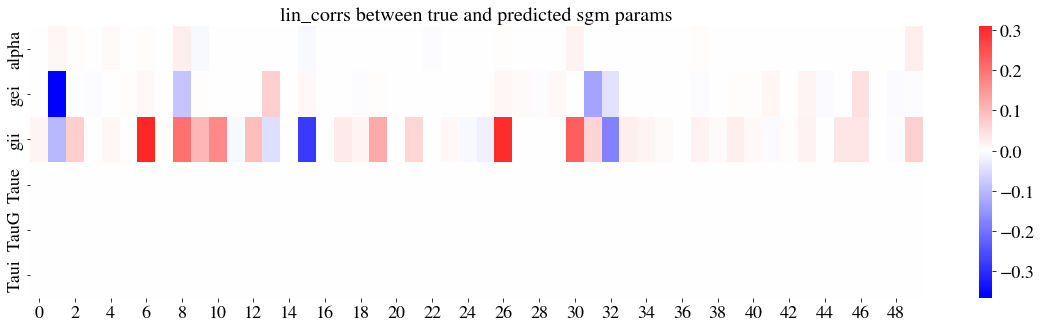

In [35]:
lin_corrs = lin_R_fn(true_params_flt, pred_params_flt).reshape(-1, num_dyn_params);

plt.figure(figsize=[20, 5])
plt.title(f"lin_corrs between true and predicted sgm params", fontsize=20)
sns.heatmap(lin_corrs.T, cmap="bwr", center=0, annot=False)
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);

### Corr between SGM params

In [36]:
corr_mats_pred = np.array([np.corrcoef(pred_params[0, :, dy_mask==1]) for sub_ix in range(pred_params.shape[0])]);
corr_mats_true = np.array([np.corrcoef(true_params[0, :, dy_mask==1]) for sub_ix in range(true_params.shape[0])]);

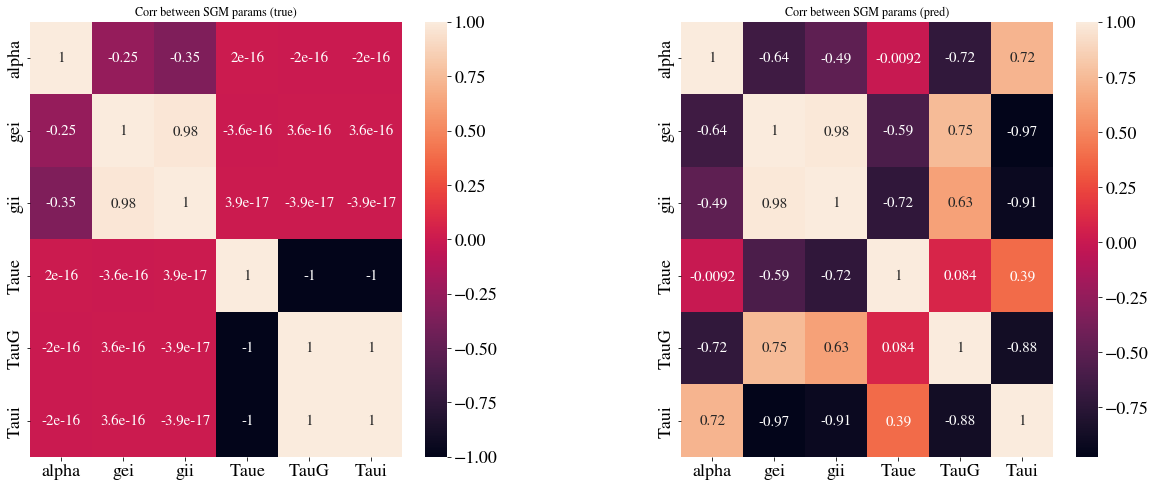

In [37]:
plt.figure(figsize=[20,8])
plt.subplot(121)
plt.title("Corr between SGM params (true)")
sns.heatmap(np.mean(corr_mats_true, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.subplot(122)
plt.title("Corr between SGM params (pred)")
sns.heatmap(np.mean(corr_mats_pred, axis=0), annot=True, annot_kws={"fontsize":15})
plt.yticks(np.arange(num_dyn_params)+0.5, dyn_names);
plt.xticks(np.arange(num_dyn_params)+0.5, dyn_names);

------

### Recontruct PSD

In [107]:
sgm_net.eval()
with torch.no_grad():
    X_rec1 = sgm_net(Y_pred)
X_rec1 = X_rec1.numpy()

X_org = simu_sgm_data.PSDs
X_org = X_org/X_org.std(axis=(1, 2), keepdims=1)

In [149]:
sgmmodel = SGM(paras.C, paras.D, paras.freqs)
X_rec2 = []
for sgm_params_cur in tqdm(Y_pred):
    cur_PSD = sgmmodel.run_local_coupling_forward(sgm_params_cur.numpy())
    X_rec2.append(cur_PSD[:68])
X_rec2 = np.array(X_rec2)
X_rec2 = X_rec2/X_rec2.std(axis=(1, 2), keepdims=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:21<00:00,  2.62it/s]


In [109]:
def ana_corr(data_org, data_rec):
    corrs_psd = []
    for ix in range(data_org.shape[0]):
        seq_x = data_org[ix]
        seq_y = data_rec[ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_psd.append(res[0])
        
        
    data_org_std = std_mat(data_org)
    data_rec_std = std_mat(data_rec)
    corr_psd_uni = scipy.stats.pearsonr(
        data_org_std.mean(axis=0), 
        data_rec_std.mean(axis=0))[0]
    
    corrs_sp = []
    for ix in range(data_org.shape[1]):
        seq_x = data_org[:, ix]
        seq_y = data_rec[:, ix]
        res = scipy.stats.pearsonr(seq_x, seq_y)
        corrs_sp.append(res[0])
    return corr_psd_uni, corrs_psd, corrs_sp

In [155]:
corrs1 = []
corrs2 = []
for ix in range(len(X_org)):
    corrs1.append(ana_corr(X_org[ix], X_rec1[ix])[0])
    corrs2.append(ana_corr(X_org[ix], X_rec2[ix])[0])
print(np.mean(corrs1), np.std(corrs1))
print(np.mean(corrs2), np.std(corrs2))

0.9484344357956783 0.08743834731049734
0.9369320017806869 0.10136407192723579


In [171]:
print(np.stack([
    np.argsort(corrs1)[:10],
    np.argsort(corrs2)[:10]]))

print(np.stack([
    np.argsort(-np.array(corrs1))[:10],
    np.argsort(-np.array(corrs2))[:10]]))

[[346 482 308 782 551 481 310 109 309 632]
 [482 346 481 782 632 551  45 309 109 308]]
[[284 295 357 336 923 695  87 381 202  86]
 [664 807 715 828 887 405 437 841 164 222]]


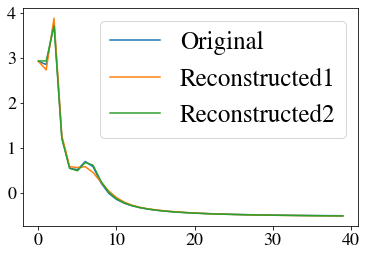

In [177]:
idx = np.argmin(corrs1)
idx = 405 
plt.plot(std_mat(X_org[idx]).mean(axis=0), label="Original")
plt.plot(std_mat(X_rec1[idx]).mean(axis=0), label="Reconstructed1")
plt.plot(std_mat(X_rec2[idx]).mean(axis=0), label="Reconstructed2")
plt.legend()

In [178]:
np.stack([ 
    simu_sgm_data.sgm_paramss[idx],
    Y_pred[idx].numpy()])

array([[6.67153059e-01, 4.68866069e-01, 1.95860934e+00, 1.30077886e-02,
        2.96239173e-02, 1.59695247e-01, 1.47868816e+01],
       [3.77303394e-01, 3.60230355e-01, 7.73818310e-01, 1.28352319e-02,
        2.95342640e-02, 1.12282176e-01, 1.95564955e+01]])

In [135]:
paras.prior_bds

array([[1.e-01, 1.e+00],
       [1.e-03, 7.e-01],
       [1.e-03, 2.e+00],
       [5.e-03, 3.e-02],
       [5.e-03, 3.e-02],
       [5.e-03, 2.e-01],
       [5.e+00, 2.e+01]])

## Save

In [136]:
trained_model = edict()
trained_model.model = rnn
trained_model.loss = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_rnn
trained_model.loss = losses
save_pkl_dict2folder(RES_ROOT/"LSTM_simu_net", trained_model, is_force=False)

/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net
Create a folder /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/LSTM_simu_net/paras.pkl
